Files already downloaded and verified


/home/aayam/micromamba/envs/mnist/lib/python3.11/site-packages/torchvision/datasets/cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")


Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9894737..2.100835].


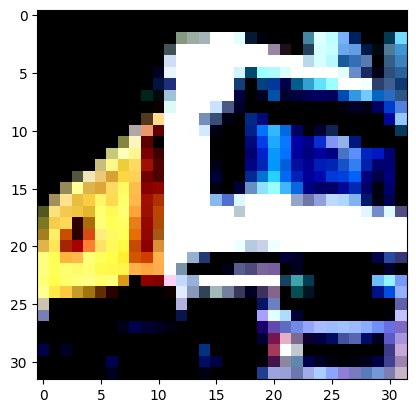

In [13]:
import torch
import torch.nn as nn
from torchvision import datasets,transforms
from torch.utils.data import DataLoader,random_split
import matplotlib.pyplot as plt


mean = (0.4914, 0.4822, 0.4465)
std  = (0.2470, 0.2435, 0.2616)

train_tf = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

test_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

train_data= datasets.CIFAR10(root="./data", train=True, transform=train_tf, download=True)
test_data= datasets.CIFAR10(root="./data", train=False, transform=test_tf, download=True)

image, label= train_data[1]

plt.imshow(image.permute(1,2,0))
plt.show()

classes = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck"
]


In [14]:
train_set, val_set= random_split(train_data, [40000,10000])

train_loader= DataLoader(train_set, batch_size= 64, shuffle=True)
val_loader= DataLoader(val_set, batch_size=64, shuffle=False)
test_loader= DataLoader(test_data, batch_size=64, shuffle=False)

print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

625
157
157


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [24]:
class ObjectClassifier(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1= nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1= nn.BatchNorm2d(32)
        self.relu1= nn.ReLU()

        self.conv2= nn.Conv2d(32, 128, kernel_size=3, stride=2, padding=1)
        self.bn2= nn.BatchNorm2d(128)
        self.relu2= nn.ReLU()

        self.conv3= nn.Conv2d(128,256, kernel_size=3, stride=1, padding=1)
        self.bn3= nn.BatchNorm2d(256)
        self.relu3= nn.ReLU()

        self.conv4= nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1)
        self.bn4= nn.BatchNorm2d(512)
        self.relu4= nn.ReLU()

        self.gap= nn.AdaptiveAvgPool2d(1)
        self.flatten= nn.Flatten()
        self.drop= nn.Dropout(0.3)
        self.fc1= nn.Linear(512,10)

    def forward(self, x):

        x = self.relu1(self.bn1(self.conv1(x)))
        x = self.relu2(self.bn2(self.conv2(x)))
        x = self.relu3(self.bn3(self.conv3(x)))
        x = self.relu4(self.bn4(self.conv4(x)))

        x = self.gap(x)        
        x = self.flatten(x)  
        x=  self.drop(x)
        x = self.fc1(x)         
        return x


In [25]:
model= ObjectClassifier().to(device)

criterion= nn.CrossEntropyLoss()

optimizer= torch.optim.AdamW(model.parameters(), lr= 0.001, weight_decay=1e-4)
scheduler= torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min', factor=0.5, patience=6)

num_epochs=30

best_loss= float("inf")

for epoch in range(num_epochs):

    model.train()
    running_loss=0

    for batch_idx, (images,labels) in enumerate(train_loader):

        images= images.to(device)
        labels= labels.to(device)

        output= model(images)
        loss= criterion(output, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if (batch_idx+1)%100==0:

            print(f"epoch [{epoch+1}/{num_epochs}] | batch [{batch_idx+1}/{len(train_loader)}] | loss : {loss.item()} ")

    average_train_loss= running_loss/len(train_loader)
    print(f"epoch {epoch+1}/{num_epochs} avg train loss: {average_train_loss} ")


    model.eval()
    with torch.no_grad():
        running_val_loss=0

        for image,label in val_loader:
            image= image.to(device)
            label= label.to(device)

            output= model(image)
            loss= criterion(output,label)

            running_val_loss+= loss.item()

        avg_val_loss= running_val_loss/len(val_loader)
        print(f"epoch {epoch+1}/{num_epochs} avg val loss: {avg_val_loss} ")

    scheduler.step(avg_val_loss)

    if avg_val_loss < best_loss:
        best_loss= avg_val_loss
        torch.save(model.state_dict(), "best_model.pth")



epoch [1/30] | batch [100/625] | loss : 1.6448547840118408 
epoch [1/30] | batch [200/625] | loss : 1.2670232057571411 
epoch [1/30] | batch [300/625] | loss : 1.3503854274749756 
epoch [1/30] | batch [400/625] | loss : 1.20161771774292 
epoch [1/30] | batch [500/625] | loss : 1.0560157299041748 
epoch [1/30] | batch [600/625] | loss : 1.1494196653366089 
epoch 1/30 avg train loss: 1.4967782550811768 
epoch 1/30 avg val loss: 1.3934705166300392 
epoch [2/30] | batch [100/625] | loss : 1.3594192266464233 
epoch [2/30] | batch [200/625] | loss : 1.1715816259384155 
epoch [2/30] | batch [300/625] | loss : 1.1051501035690308 
epoch [2/30] | batch [400/625] | loss : 1.094744086265564 
epoch [2/30] | batch [500/625] | loss : 0.94996577501297 
epoch [2/30] | batch [600/625] | loss : 1.1734271049499512 
epoch 2/30 avg train loss: 1.1808737441062926 
epoch 2/30 avg val loss: 1.1160989525211844 
epoch [3/30] | batch [100/625] | loss : 1.1206477880477905 
epoch [3/30] | batch [200/625] | loss : 1

In [26]:
model.load_state_dict(torch.load("best_model.pth", map_location=device))
model.to(device)

total=0
correct=0

model.eval()
with torch.no_grad():
    for images,labels in test_loader:
        images= images.to(device)
        labels= labels.to(device)

        output=model(images)
        _,predicted= torch.max(output,1)

        total+= images.size(0)
        correct+= (predicted == labels).sum().item()

    accuracy= 100 * correct/total
    print(accuracy)


/tmp/ipykernel_17098/1644180327.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth", map_location=device))


83.68
